# Recommendation Systems - Constructing Rating Models


* Shachar Wild   


*  Jonthan Morag  




In this work, we attempt to examine the world of Recommendion Systems, by constructing rating models. We will construct the following models:

*   SVD 
*   SVD++ 
*   Content Model
*   Ensemble Model

We will train and evaluate each one sepertaly and then eventually compare their performance to one another in order to determine which one is the optimal for our task (which is predicting rating for Yelp). The pipeline will include: Data reading, data cleansing and pre-processing, models implementation, evaluation of each one and a through comparison to one another, based on our chosen metrics. It is also important to note that all the models will be trained and evaluated using the same train and test sets' original data (the same split) in order to avoid any bias when comparing their performance.     

Dependencies: pandas, numpy, sklearn, tqdm, matplotlib, plotly, seaborn

Requirements: 16 GB or more of available RAM

The default location for data files is the present working directory. If data is located elsewhere, you should modify DATA_DIR below.

## Imports and Installs

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import math
from operator import itemgetter 
from tqdm import tqdm
import matplotlib.pyplot as plt  
from itertools import product
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import time
from collections import defaultdict
import itertools  
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cat /proc/cpuinfo

Mounted at /content/drive
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address size

In [ ]:
DATA_DIR = '.'
DATA_DIR = '/content/drive/Shareddrives/Shachar_Jonathan_RS/data/Yelp-Assignment1'
MODELS_DIR = DATA_DIR
MODELS_DIR = '/content/drive/Shareddrives/Shachar_Jonathan_RS/Ass1'

## Part 1  - Data and Metrics

### Data loading

First, we will load the train and test data, which will be used for constructing the SVD model. It is consisted of user id's, item id's and ratings for each given pair, ranking from 1 to 5.
Since the data is stored in a tabuler format, we will use dataframe.
We will also ensure that these data sets do no contain any empty values. 

In [ ]:
def Load(data_dir='.') -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, tuple, LabelEncoder, LabelEncoder,
                           pd.DataFrame, pd.DataFrame):
    # MF model

    # read data
    train_data_name = 'userTrainData.csv'
    test_data_name = 'userTestData.csv'
    user_id = 'user_id'
    business_id = 'business_id'
    columns = [user_id, business_id, 'stars']
    d_types = {user_id: str, business_id: str, 'stars': int}
    # get train data
    train_data = pd.read_csv(os.path.join(data_dir, train_data_name), usecols=columns, dtype=d_types, index_col=False)
    test_data = pd.read_csv(os.path.join(data_dir, test_data_name), usecols=columns, dtype=d_types, index_col=False)
    valid_user_ids, valid_business_ids = set(train_data[user_id]), set(train_data[business_id])
    le_users, le_businesses = LabelEncoder(), LabelEncoder()
    le_users.fit(train_data[user_id]), le_businesses.fit(train_data[business_id])
    train_data[user_id], train_data[business_id] = \
        le_users.transform(train_data[user_id]), le_businesses.transform(train_data[business_id])
    R_matrix_shape = (max(train_data[user_id]) + 1, max(train_data[business_id]) + 1)
    # split to train and validation
    train_data_only_uniques = train_data[train_data.groupby(user_id).user_id.transform('count') == 1]
    train_data_only_uniques = train_data_only_uniques[train_data_only_uniques.groupby(business_id).business_id.transform('count') == 1]
    train_data = train_data[train_data.groupby(user_id).user_id.transform('count') > 1]
    train_data = train_data[train_data.groupby(business_id).business_id.transform('count') > 1]
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
    # make sure we don't have ids in validation that are missing from train
    unique_in_val = ~(val_data[user_id].isin(train_data[user_id].unique())) | ~(val_data[business_id].isin(train_data[business_id].unique()))
    unique_in_val = val_data[unique_in_val]
    train_data = train_data.append(unique_in_val, ignore_index=True)
    val_data.drop(unique_in_val.index, inplace=True)
    
    train_data = pd.concat([train_data, train_data_only_uniques])
    
    # get test data
    test_data = test_data[(test_data[user_id].isin(valid_user_ids)) & (test_data[business_id].isin(valid_business_ids))]
    test_data[user_id], test_data[business_id] = \
        le_users.transform(test_data[user_id]), le_businesses.transform(test_data[business_id])
    test_data.sort_values(by='user_id', inplace=True, ascending=True)

    # content model
    # business_data_name = '/content/drive/Shareddrives/Shachar_Jonathan_RS/data/Yelp-Assignment1/yelp_business.csv'
    # user_data_name = '/content/drive/Shareddrives/Shachar_Jonathan_RS/data/Yelp-Assignment1/yelp_user.csv'
    business_data_name = 'yelp_business.csv'
    user_data_name = 'yelp_user.csv'
    user_features = pd.read_csv(os.path.join(data_dir, user_data_name))
    business_features = pd.read_csv(os.path.join(data_dir, business_data_name))
    user_features, business_features = user_features[user_features[user_id].isin(valid_user_ids)], \
                               business_features[business_features[business_id].isin(valid_business_ids)]
    user_features[user_id] = le_users.transform(user_features[user_id])
    business_features[business_id] = le_businesses.transform(business_features[business_id])

    return train_data, val_data, test_data, R_matrix_shape, le_users, le_businesses, user_features, business_features

In [ ]:
train_data, val_data, test_data, R_matrix_shape, le_users, le_businesses, user_features, business_features = Load(data_dir=DATA_DIR)

An overview of the train data:

In [ ]:
train_data.head()

,user_id,business_id,stars
0,80380,139058,5
1,16004,43647,4
2,3635,129390,5
3,56422,153681,4
4,167219,63814,4


When splitting the train data to train set and validation set, we first wanted to ensure that each user in the validation set will be presented in the train set as well. This due to the fact that in the training phase we attempt to identify the optimal latent feature vector of each user. However, If we have a new, unseen user in the validation set, when predicting its rating to a particular item, the prediction algorithm wil consider only its initialized features vector. It is important to note that we also verified that users which appeared only once in the training set, will not be presented in the validation set, for the reason mentioned above. 

We also denoated unique indexes:


*   User index - ranging from 0 to n (number of users in the data) 
*   Item index - ranking from 0 to m (number of items in the data)

This was done in order to identify a particular user and item in a convinent way and in a reasonable time, when calculating their predicted rating and also when attempting to locate their true rating.


### Data Exploration

We will perform data exploration in order to learn it in more depth and get insights regarding the values distirubtion within it. 

In [ ]:
print(f'number of training samples: {train_data.shape[0]: ,d}')
print(f'number of validation samples: {val_data.shape[0]: ,d}')
print(f'number of testing samples: {test_data.shape[0]: ,d}')
print(f'number of missing ratings: {train_data["stars"].isnull().sum().sum(): ,d}')
print(f'average rating in train data: {np.mean(train_data["stars"].to_numpy()): .2f}')
print(f'median rating in train data: {int(np.median(train_data["stars"].to_numpy())): ,d}')
print(f'variance of ratings in train data: {np.var(train_data["stars"].to_numpy()): .2f}')

number of training samples:  1,826,145
number of validation samples:  450,980
number of testing samples:  569,025
number of missing ratings:  0
average rating in train data:  3.74
median rating in train data:  4
variance of ratings in train data:  1.78


We can see that there are no missing ratings, which is good. Moreover, the median rating is relatively high and stands for 4 (out of 5). Furthermore, the number of records is very large, which may assist as in constructing reliable models. The variance is not low, which makes the ratings different from each other. 

Next, we will explore the rating column, and see the internal distribution within it:

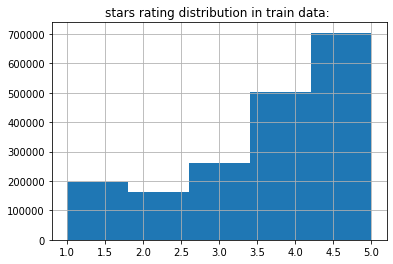

In [ ]:
plt.title('stars rating distribution in train data: ')
train_data['stars'].hist(bins=5);

We can see that  most of the ratings were relatively high (above 4) for all the items presented in the train data. We can deduce that the users were rather "forgiving" and optimistic regarding their item-using experience.

After viewing the ratings distribution, we would want to examine the number of ratings each item got, instead of the values of the ratings its-self. Since there are many items, it is important to check whether the distribution is balanced. We will perform this procedure both the train set.

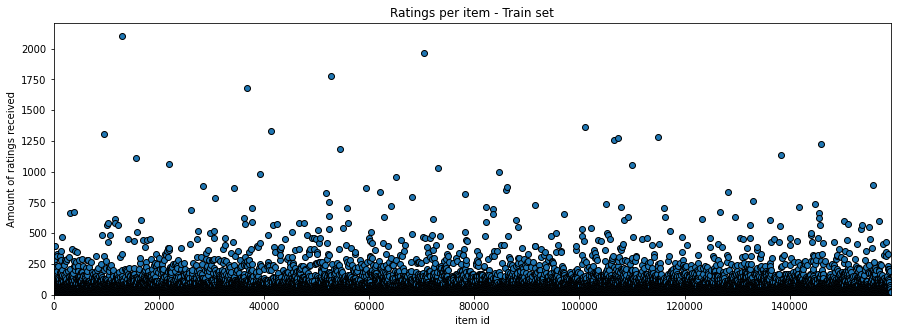

In [ ]:
dftmp = train_data[['user_id', 'business_id']].groupby('business_id').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per item - Train set')
plt.xlabel('item id')
plt.ylabel('Amount of ratings received')
plt.show()

Viewing the above graphs, we can see that for most of the items, the number of ratings is relatively the same, besides a few outliers which had a large number of ratings (above 700). 




Next, we will examine a sample of features data:

User features:

In [ ]:
list(user_features.columns)

['user_id',
 'name',
 'review_count',
 'yelping_since',
 'friends',
 'useful',
 'funny',
 'cool',
 'fans',
 'elite',
 'average_stars',
 'compliment_hot',
 'compliment_more',
 'compliment_profile',
 'compliment_cute',
 'compliment_list',
 'compliment_note',
 'compliment_plain',
 'compliment_cool',
 'compliment_funny',
 'compliment_writer',
 'compliment_photos']

Business (item) features:

In [ ]:
list(list(business_features.columns))

['business_id',
 'name',
 'neighborhood',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'categories']

We will examine the percentage of missing values in each column:

User features:

In [ ]:
user_df = pd.DataFrame()
features_name =[]
missing_values = []

print(f'user features: {list(user_features.columns)[1:]}')
print('% missing values per feature with missing values:')
for col in list(user_features.columns):
    num_na = user_features[col].isin({"None", np.NAN, None, ""}).sum()
    if num_na > 0:
        print(f'{col} missing values %: {float(num_na) / user_features.shape[0]}')
    features_name.append(col) 
    missing_values.append(float(num_na) / user_features.shape[0]) 

user_df['Feature'] = features_name
user_df['Missing Value Percentage'] = missing_values

user features: ['name', 'review_count', 'yelping_since', 'friends', 'useful', 'funny', 'cool', 'fans', 'elite', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']
% missing values per feature with missing values:
name missing values %: 0.00015480718137962486
friends missing values %: 0.2716866033212416
elite missing values %: 0.8655646068943588


In [ ]:
user_df

,Feature,Missing Value Percentage
0,user_id,0.000000
1,name,0.000155
2,review_count,0.000000
3,yelping_since,0.000000
4,friends,0.271687
5,useful,0.000000
6,funny,0.000000
7,cool,0.000000
8,fans,0.000000
9,elite,0.865565


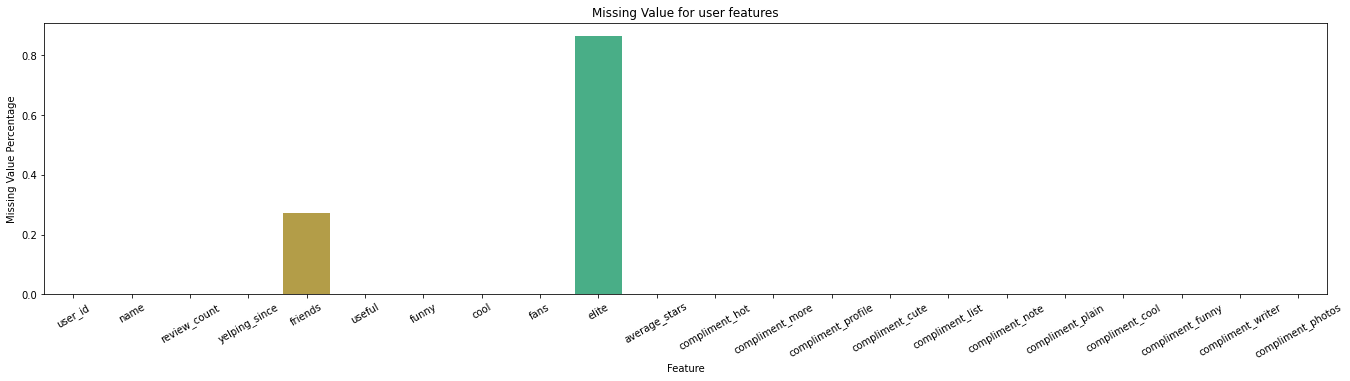

In [ ]:
plt.figure(figsize=(23,5))

ax = sns.barplot(x="Feature", y="Missing Value Percentage", data=user_df);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
ax.set(title='Missing Value for user features');

We can see that the "elite" feature has a very high percentage of missing values (close to 0.9), followed by the "friends" feature. 
Although that are various missing values handling methods, the "elite" feature will not be informative enough, since its mostly empty.

Buisness (items) features:

In [ ]:
item_df = pd.DataFrame()
features_name =[]
missing_values = []

print(f'\nbusiness features: {list(business_features.columns)[1:]}')
print('% missing values per feature with missing values:')
for col in list(business_features.columns):
    num_na = business_features[col].isin({"None", np.NAN, None, ""}).sum()
    if num_na > 0:
        print(f'{col} missing values %: {float(num_na) / business_features.shape[0]}')
    features_name.append(col) 
    missing_values.append(float(num_na) / user_features.shape[0]) 

item_df['Feature'] = features_name
item_df['Missing Value Percentage'] = missing_values


business features: ['name', 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories']
% missing values per feature with missing values:
neighborhood missing values %: 0.603613791716928
city missing values %: 6.282669883393647e-06
state missing values %: 6.282669883393647e-06
postal_code missing values %: 0.003166465621230398
latitude missing values %: 6.282669883393647e-06
longitude missing values %: 6.282669883393647e-06


In [ ]:
item_df

,Feature,Missing Value Percentage
0,business_id,0.000000
1,name,0.000000
2,neighborhood,0.401980
3,address,0.000000
4,city,0.000004
5,state,0.000004
6,postal_code,0.002109
7,latitude,0.000004
8,longitude,0.000004
9,stars,0.000000


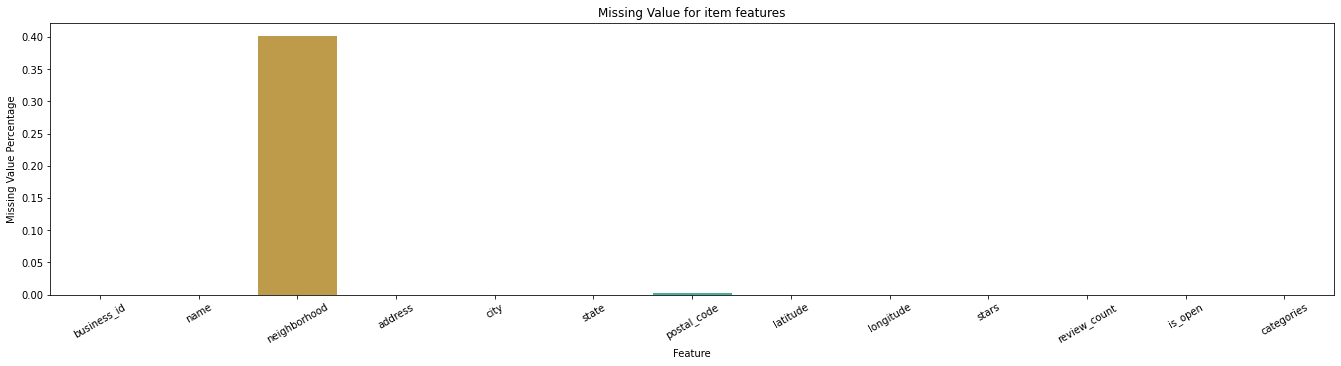

In [ ]:
plt.figure(figsize=(23,5))

ax = sns.barplot(x="Feature", y="Missing Value Percentage", data=item_df);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
ax.set(title='Missing Value for item features');

We can see that the "neighborhood" feature has the highest percentage of missing values, around 0.4.

When constructing the content model, we will take into account these features and examine if and how it will use them.


### RMSE measure

The following is an implementation of the RMSE measure, as requested in the assignment:

In [ ]:
def calculate_RMSE(r_real, r_pred):  
  MSE = np.square(np.subtract(r_real,r_pred)).mean() 
  RMSE = math.sqrt(MSE)
  return RMSE

### MAE measure

As another evaluation measure, we propose Mean Absolute Error, MAE in short. As explained in the assignment, we explore the task of predicting rating, which is a numeric variable. This can be referred as a regression task. As such, we chose to examine MAE measure since it is a common measure that is used to evaluate how good a regression model is. It measures the average magnitude of the errors in a set of predictions, without considering their direction. It is defined as the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

In [ ]:
def calculate_MAE(r_real, r_pred):
  sum_error = 0.0
  for i in range(len(r_real)):
    sum_error += abs(r_pred[i] - r_real[i])
  return sum_error  / float(len(r_real))

### RMSE Class-Wise

In [ ]:
def RMSE_class_wise(r_real, r_pred):

  ratings = [1,2,3,4,5]
  all_RMSE = []
  for rating in ratings:
    relevant_indexes = [i for i, n in enumerate(r_real) if n == rating]
    real_single_class =  [r_real[index] for index in relevant_indexes]
    pred_single_class =  [r_pred[index] for index in relevant_indexes]
    rmse = calculate_RMSE(real_single_class, pred_single_class)
    all_RMSE.append(rmse)
    
  return ratings, all_RMSE

## Part 3 - SVD (MF)

### SVD Implementation

In this part, we will implement SVD model, as learned in the lecture and followed by the course's book.
As such, we will construct and maintain four main data structures:


1.   User factors matrix - This matrix will contain all the latent factors vector of each user.
2.   Item factors matrix - This matrix will contain all the latent factors of each item.
3.   User bias vector - This vector will contain the rating bias of each user.
4.   Item bias vector - This vector will contain the rating bias of each item.

These data structures will be constructed based on the train data, and will be updated in a descending gadient process, along the training phase. In other words, the model will learn what are the best factors and biases of the users, which should result in an efficient rating prediction. 
Eventually, the trained model will be consisted of these updated data structures and thus will be able to make a prediction based on the test data.
It is important to note that the train data will serve as the R matrix, and will consist of all the available user-item rankings. 

In [ ]:
def PredictRatingSVD(mean_rating,b_i, b_u, p_u, q_i):
  features_score = sum(np.multiply(q_i, p_u))
  r_pred =  mean_rating + b_i + b_u + features_score
  return r_pred 

In [ ]:
def AdjustParametersSVD(b_u, b_i, q_i, p_u, e, gamma, lamda):
  new_b_u = b_u + gamma*(e-lamda*b_u)
  new_b_i = b_i + gamma*(e-lamda*b_i)
  new_q_i = q_i + gamma*(e*p_u-lamda*q_i)
  new_p_u = p_u + gamma*(e*q_i-lamda*p_u)

  return new_b_u, new_b_i, new_q_i, new_p_u

In [ ]:
best_SVD_val_RMSE = float('inf') # will be updated in the training phase

def TrainBaseModel(num_latent_features, gamma, lamda):
  global best_SVD_val_RMSE
  # Mean rating (miu)
  all_rating = list(train_data['stars'])
  mean_rating = sum(all_rating) / len(all_rating)

  # Initialize b_u for each user 
  users = list(range(0,R_matrix_shape[0]+1))
  users.sort()
  b_u = [0.5] * len(users)
  users_b = dict(zip(users, b_u))

  # Initialize b_i for each item 
  items = list(range(0,R_matrix_shape[1]+1))
  items.sort()
  b_i = [0.5] * len(items)
  items_b = dict(zip(items, b_i))
  
  # Initialize p_u for each user  
  p_u = np.array([[0.1]*num_latent_features] * len(users))
  users_matrix = p_u.reshape(len(p_u), (num_latent_features))

  # Initialize q_i for each item  
  q_i = np.array([[0.1]*num_latent_features] * len(items))
  items_matrix = q_i.reshape(len(q_i), (num_latent_features))

  previous_RMSE = 100000
  current_RMSE = 10000
  epsilon = 0.01
  num_iteration = 1
  # main loop
  while current_RMSE < previous_RMSE and previous_RMSE - current_RMSE > epsilon:
    previous_RMSE = current_RMSE

    # Iterate through training set
    for index, row in train_data.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]   

      # predict rating
      r_pred = PredictRatingSVD(mean_rating,b_i, b_u, p_u, q_i)
      
      # calculate error
      e = r_real - r_pred

      # Adjust and update parameters
      b_u, b_i, q_i, p_u = AdjustParametersSVD(b_u, b_i, q_i, p_u, e, gamma, lamda)
      users_matrix[user] = p_u
      items_matrix[item] = q_i
      users_b[user] = b_u 
      items_b[item] = b_i 
  
    # iterate through validation set
    all_r_pred = []
    all_r_real = []
    for index, row in val_data.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]   

      # predict rating
      r_pred = PredictRatingSVD(mean_rating,b_i, b_u, p_u, q_i)

      # calculate RMSE
      all_r_pred.append(r_pred)
      all_r_real.append(r_real)

    current_RMSE = calculate_RMSE(all_r_real, all_r_pred) 
    best_SVD_val_RMSE = current_RMSE
    current_MAE = calculate_MAE(all_r_real,all_r_pred )
    print('Iteration number:', num_iteration, '.Validation RMSE is:', current_RMSE, '.Validation MAE is:', current_MAE )  
    num_iteration +=1

  return [users_matrix, items_matrix, users_b, items_b]

In [ ]:
# train the model  
num_factors = 20
gamma = 0.005
lamda = 0.02

SVD_model = TrainBaseModel(num_factors, gamma, lamda)

Iteration number: 1 .Validation RMSE is: 1.5195522071469838 .Validation MAE is: 1.0669002326940158
Iteration number: 2 .Validation RMSE is: 1.431785228061287 .Validation MAE is: 1.0195701170545903
Iteration number: 3 .Validation RMSE is: 1.3829603813410734 .Validation MAE is: 0.997019185963822
Iteration number: 4 .Validation RMSE is: 1.350580749761893 .Validation MAE is: 0.9831426982832104
Iteration number: 5 .Validation RMSE is: 1.3270597681436997 .Validation MAE is: 0.973399193766581
Iteration number: 6 .Validation RMSE is: 1.309000734499033 .Validation MAE is: 0.9660681449592191
Iteration number: 7 .Validation RMSE is: 1.2946113491980897 .Validation MAE is: 0.9602914213030272
Iteration number: 8 .Validation RMSE is: 1.2828380975343106 .Validation MAE is: 0.9555722336664583
Iteration number: 9 .Validation RMSE is: 1.2730127709133823 .Validation MAE is: 0.9516344459956031


### Evaluate on Test Set


After training a SVD model, we can now make a rating prediction based on the test data, in order to examine how efficient our model is. 

In [ ]:
# Predict on test set and return all predictions
def SVDGetPredictions(SVD_model, dataset):
  users_matrix, items_matrix, users_b, items_b = SVD_model[0], SVD_model[1], SVD_model[2], SVD_model[3]
  all_rating = list(train_data['stars'])
  mean_rating = sum(all_rating) / len(all_rating)
  all_r_pred = []
  all_r_real = []

  for index, row in dataset.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]

      # predict rating
      r_pred = PredictRatingSVD(mean_rating,b_i, b_u, p_u, q_i)

      # calculate RMSE
      all_r_pred.append(r_pred)
      all_r_real.append(r_real)
  return all_r_pred


# Predict on test set and return RMSE and MAE
def SVDTestPrediction(SVD_model):
  users_matrix, items_matrix, users_b, items_b = SVD_model[0], SVD_model[1], SVD_model[2], SVD_model[3]
  all_rating = list(train_data['stars']) 
  mean_rating = sum(all_rating) / len(all_rating)
  all_r_pred = []
  all_r_real = []
  
  for index, row in test_data.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]   

      # predict rating
      r_pred = PredictRatingSVD(mean_rating,b_i, b_u, p_u, q_i)

      # calculate RMSE
      all_r_pred.append(r_pred)
      all_r_real.append(r_real)

  RMSE = calculate_RMSE(all_r_real, all_r_pred) 
  print('The RMSE of SVD for', num_factors, 'latent features is:',RMSE)

  MAE = calculate_MAE(all_r_real,all_r_pred)
  print('The MAE of SVD for', num_factors, 'latent features is:',MAE)

  return RMSE, MAE

In [ ]:
RMSE, MAE = SVDTestPrediction(SVD_model)

The RMSE of SVD for 20 latent features is: 1.2744671910783822
The MAE of SVD for 20 latent features is: 0.9539485657540977


Both of the metrics values seem to be low, which is good. It will also be interesting to examine the RMSE for each given class separately. In other words, we will evaluate the already trained model for each class separately. In each evaluation, the test set will only be consisted of one class value. As following:

In [ ]:
ratings = [1,2,3,4,5]
SVD_RMSE = []

original_test_set = test_data.copy()

# In each iteration, the test set will only be consisted of one class value.
for rating in ratings:
  print('Evaluating SVD for a target value of only:', rating)
  test_data = original_test_set[original_test_set['stars'] == rating]
  RMSE, MAE = SVDTestPrediction(SVD_model)
  SVD_RMSE.append(RMSE)
  print('--------------------------------------------------------------')
test_data = original_test_set # back to original test_data

Evaluating SVD for a target value of only: 1
The RMSE of SVD for 20 latent features is: 2.808642400799926
The MAE of SVD for 20 latent features is: 2.7256286465001067
--------------------------------------------------------------
Evaluating SVD for a target value of only: 2
The RMSE of SVD for 20 latent features is: 1.779832382327965
The MAE of SVD for 20 latent features is: 1.6857378120293838
--------------------------------------------------------------
Evaluating SVD for a target value of only: 3
The RMSE of SVD for 20 latent features is: 0.8943607633623031
The MAE of SVD for 20 latent features is: 0.7716422002072504
--------------------------------------------------------------
Evaluating SVD for a target value of only: 4
The RMSE of SVD for 20 latent features is: 0.49022971614597255
The MAE of SVD for 20 latent features is: 0.3878378230367703
--------------------------------------------------------------
Evaluating SVD for a target value of only: 5
The RMSE of SVD for 20 latent fe

In [ ]:
rmse_table = pd.DataFrame()
rmse_table['ratings'] = ratings
rmse_table['RMSE'] = SVD_RMSE

rmse_table

,ratings,RMSE
0,1,2.808642
1,2,1.779832
2,3,0.894361
3,4,0.490230
4,5,0.903626


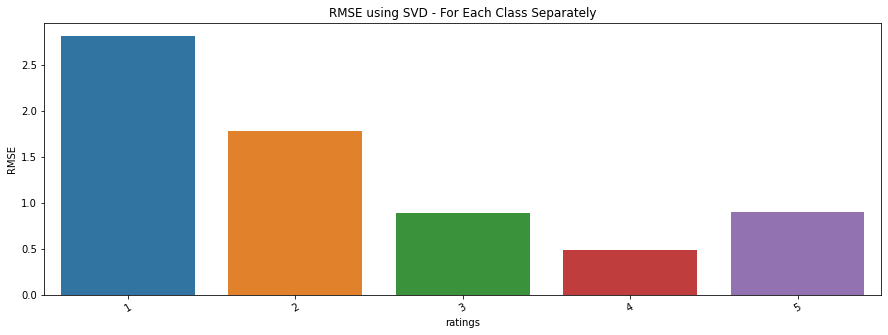

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x="ratings", y="RMSE", data=rmse_table);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
ax.set(title='RMSE using SVD - For Each Class Separately');

Viewing the above graph, we can see that the model performed worst when only given class 1, followed by class 2. On the other hands, the model performed best and managed to achieve a very low RMSE value (under 0.5) when only evaluating class number 4.



 ### Adjustment of γ and λ 

In attempt to improve the metrics, we will use the recommended learning rates' values that are presented in the course book. We will examine whether using said values improve our examined metrics. We will also perform gridsearch operation and to examine all sort of value combinations of these two learning rates parameters. Eventually, we will compare the metrics results for each given value combinations, and determine the optimal one. It is importnat to note that the range of the examined values will not be too varied, since the run time is limited. 

In [ ]:
gamma_values = np.array([0.001, 0.003, 0.005])
lamda_values = np.array([0.02, 0.06])
SVD_models = []
num_factors = 20

for gamma, lamda in product(gamma_values, lamda_values):
    print('Training model with learning rates of gamma =',gamma,'and lamda =',lamda, ':')
    print('-----------------------------------------------------------------------------------')
    trained_model = TrainBaseModel(num_factors, gamma, lamda)
    SVD_models.append(trained_model)
    print('-----------------------------------------------------------------------------------')


Training model with learning rates of gamma = 0.001 and lamda = 0.02 :
-----------------------------------------------------------------------------------
Iteration number: 1 .Validation RMSE is: 1.6900326899658462 .Validation MAE is: 1.1766348047485788
Iteration number: 2 .Validation RMSE is: 1.6276644925946049 .Validation MAE is: 1.1354175610380834
Iteration number: 3 .Validation RMSE is: 1.5827688194046785 .Validation MAE is: 1.1061411414808597
Iteration number: 4 .Validation RMSE is: 1.5480999435220084 .Validation MAE is: 1.0841897632399584
Iteration number: 5 .Validation RMSE is: 1.520169113013334 .Validation MAE is: 1.067207836219243
Iteration number: 6 .Validation RMSE is: 1.4969920705805047 .Validation MAE is: 1.053726752558765
Iteration number: 7 .Validation RMSE is: 1.4773290322093344 .Validation MAE is: 1.0428259706258434
Iteration number: 8 .Validation RMSE is: 1.4603552581861596 .Validation MAE is: 1.0338380489060552
Iteration number: 9 .Validation RMSE is: 1.4454963372493

In [ ]:
# Predicting for test set for each combinations model
all_RMSE = []
all_MAE =[]
combinations = list(product(gamma_values, lamda_values))
for index, model in enumerate(SVD_models):
    gamma = combinations[index][0]
    lamda = combinations[index][1]
    print('-----------------------------------------------------------------------------------')
    print('Testing model with learning rates of gamma =',gamma,'and lamda =',lamda, ':')
    print('-----------------------------------------------------------------------------------')
    RMSE, MAE = SVDTestPrediction(model)
    all_RMSE.append(RMSE)
    all_MAE.append(MAE)
    print(' ')

-----------------------------------------------------------------------------------
Testing model with learning rates of gamma = 0.001 and lamda = 0.02 :
-----------------------------------------------------------------------------------
The RMSE of SVD for 20 latent features is: 1.402129021841937
The MAE of SVD for 20 latent features is: 1.0061057137163945
 
-----------------------------------------------------------------------------------
Testing model with learning rates of gamma = 0.001 and lamda = 0.06 :
-----------------------------------------------------------------------------------
The RMSE of SVD for 20 latent features is: 1.4007151483870781
The MAE of SVD for 20 latent features is: 1.0059762534633288
 
-----------------------------------------------------------------------------------
Testing model with learning rates of gamma = 0.003 and lamda = 0.02 :
-----------------------------------------------------------------------------------
The RMSE of SVD for 20 latent feature

Next, we will compare the evaluations of our SVD model, for each examined learning rates combination

In [ ]:
# Comparison table 
gammas = []
lamdas = []

for gamma, lamda in product(gamma_values, lamda_values):
  gammas.append(gamma)
  lamdas.append(lamda)

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Gamma', 'Lamda', 'RMSE', 'R-Square'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[gammas, # 1st column
                       lamdas, all_RMSE, all_MAE], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=600, height=350)
fig.show()

In [ ]:
# Comparison graph
comparison_df = pd.DataFrame()
comparison_df['gammas'] = gammas
comparison_df['lamdas'] = lamdas
comparison_df['RMSE'] = all_RMSE
comparison_df['MAE'] = all_MAE

comparison_df['gammas'] = comparison_df.gammas.astype(str)
comparison_df['lamdas'] = comparison_df.lamdas.astype(str)
comparison_df["Learning_rates"] = 'Gamma:' + comparison_df["gammas"] + '\n' +'Lamda:' +comparison_df["lamdas"]

fig = go.Figure(data=[
    go.Bar(name='RMSE', x=comparison_df['Learning_rates'], y=comparison_df['RMSE']),
    go.Bar(name='MAE', x=comparison_df['Learning_rates'], y=comparison_df['MAE'])
])
# Change the bar mode
fig.update_layout(barmode='group',  title={'text': "SVD - Learning Parameters Effect on Overall Performance (20 Latent Features)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, xaxis_title="Parameters values", yaxis_title="Metric score")
fig.update_xaxes(title_font_family="Arial")


fig.show()

As seen in the table and in the graph above, the optimal values for our examined learning rates are:


*   Gamma =  0.005
*   Lamda =  0.02

Training the model using these parameters values resulted in the lowest metrics score (both RMSE and MAE) when evaluating it on the Test set. 
These values are similiar to the ones that are recommended in the course's book. When comparing the SVD performance in the next sections, we will train the model on these learning parameters, in order to represent it in the most efficient way. 


## Part 4 - SVD++

### SVD++ Implementation

The suggested article proposed two novel SVD variations, which attempted to improve the basic SVD model. 

We chose to examine the first one, which is SVD++.

In order to implement this algoritm, we defined a new matrix, called "Implicit items factors". This matrix will contain the implicit factors for each item in the data set. The number of Implicit factors will be equal to this of the latent factors. We consider implicit factors as to whether a user rated an item atleast once. Whether a user rated item or not is an implict information regarding its preference. For that add two new data structures, in addition to the ones we had in the base SVD:


*   Implicit items factors matrix, as explained above (may also be called Y matrix, in our case). 
*   Array which will contain the items that were rated by each user.

As explained in part 1, we proccessed the data such that the id of each item and user represnts their correpsonding index in our dataset (In the aim of improving the runtime of the algorithms). 
Moreover, as explained in the SVD section, the first four data structures (the explicit factors matrices and the biases) will be adjusted here as well, as well as the two new additional data structures (implicit factors matrix and the rated items of each user). The adjustment will be based the gradient descent process, according to the given article and the course's book. We decided to reduce the learning parameter (gamma) by a factor of 0.9 after each parameter adjustment, and set it back to its original value when it was too small (lower than 0.004). We did that in order to prevent the learning steps to be too small, while also not cause any infinite values. 



In [ ]:
def UserRatedItem():
  all_users = list(range(0,R_matrix_shape[0]+1))
  users_implicit = [[] for i in range(len(all_users))]
  
  # Iterate through training set
  for index, row in train_data.iterrows():
    user = row['user_id']
    item = row['business_id']
    users_implicit[user].append(item)

  return users_implicit    

In [ ]:
def PredictImprovedRating(mean_rating,b_i, b_u, p_u, q_i, implict_items_matrix, all_yj):
  # calculate root square of number of items
  root_num_items = 1 / len(all_yj)**(1/2)

  # sum all yj
  sum_yj = np.add.reduce(all_yj)

  # implicit score
  implicit_vector = [factor * root_num_items for factor in sum_yj]

  # calculate final score
  sograim = np.add.reduce([p_u, implicit_vector])
  features_score = sum(np.multiply(q_i, sograim))
  r_pred =  mean_rating + b_i + b_u + features_score
  return r_pred 

In [ ]:
def AdjustImprovedParameters(b_u, b_i, q_i, p_u, e, implict_items_matrix, rated_items, all_yj, gamma, lamda1, lamda2):
  # update b_u
  new_b_u = b_u + gamma*(e-lamda1*b_u)

  # update b_i
  new_b_i = b_i + gamma*(e-lamda1*b_i)

  # calculate root square of number of items
  root_num_items = 1 / len(rated_items)**(1/2)

  # sum all yj
  sum_yj = np.add.reduce(all_yj)

  # implicit score
  implicit_vector = [factor * root_num_items for factor in sum_yj]
  sograim = np.add.reduce([p_u, implicit_vector])
  
  # update q_i
  temp = np.subtract(e*sograim , lamda2*q_i)
  new_q_i = q_i + gamma*temp

  # update p_u
  new_p_u = p_u + gamma*np.subtract(e*q_i,lamda2*p_u)

  # update implicit items matrix - for each item of this user
  for item in rated_items:
    yj = implict_items_matrix[item]
    sograim = np.subtract(e*root_num_items*q_i  ,lamda2*yj)
    new_yj = yj + gamma*sograim
    implict_items_matrix[item] = new_yj

  return new_b_u, new_b_i, new_q_i, new_p_u, implict_items_matrix

In [ ]:
# SVD++
best_SVD_plus_val_RMSE = float('inf') # will be updated in the training phase

def TrainImprovedModel(num_latent_features, gamma, lamda1, lamda2):
  global best_SVD_plus_val_RMSE
  # Mean rating (miu)
  all_rating = list(train_data['stars'])
  mean_rating = sum(all_rating) / len(all_rating)

  # Initialize b_u for each user 
  users = list(range(0,R_matrix_shape[0]+1))
  users.sort()
  b_u = [0.5] * len(users)
  users_b = dict(zip(users, b_u))

  # Initialize b_i for each item 
  items = list(range(0,R_matrix_shape[1]+1))
  items.sort()
  b_i = [0.5] * len(items)
  items_b = dict(zip(items, b_i))
  
  # Initialize p_u for each user  
  p_u = np.array([[0.1]*num_latent_features] * len(users))
  users_matrix = p_u.reshape(len(p_u), (num_latent_features))

  # Initialize q_i for each item  
  q_i = np.array([[0.1]*num_latent_features] * len(items))
  items_matrix = q_i.reshape(len(q_i), (num_latent_features))

  # Initialize impliact_factors matrix for each item  
  y_j = np.array([[0.1]*num_latent_features] * len(items))
  implict_items_matrix = y_j.reshape(len(y_j), (num_latent_features))

  # Rated items for each user
  users_implicit = UserRatedItem()

  previous_RMSE = 100000
  current_RMSE = 10000
  epsilon = 0.01
  num_iteration = 1
  initial_gamma = gamma

  # main loop
  while current_RMSE < previous_RMSE and previous_RMSE - current_RMSE > epsilon:
    gamma = initial_gamma
    previous_RMSE = current_RMSE
    # Iterate through training set
    for index, row in train_data.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]   

      # extract rated items of user
      rated_items = users_implicit[user]
      
      # get all yj of this user
      all_yj = np.take(implict_items_matrix, rated_items, axis=0) 

      # predict rating
      r_pred = PredictImprovedRating(mean_rating,b_i, b_u, p_u, q_i, implict_items_matrix, all_yj)
      
      # calculate error
      e = r_real - r_pred
      
      # Adjust and update parameters
      b_u, b_i, q_i, p_u, implict_items_matrix = AdjustImprovedParameters(b_u, b_i, q_i, p_u, e, implict_items_matrix, rated_items, all_yj,gamma, lamda1, lamda2)
      users_matrix[user] = p_u
      items_matrix[item] = q_i
      users_b[user] = b_u 
      items_b[item] = b_i 

      gamma = gamma*0.9
      if gamma < 0.004:
        gamma = initial_gamma

    # iterate through validation set
    all_r_pred = []
    all_r_real = []
    for index, row in val_data.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]   

      # extract rated items of user
      rated_items = users_implicit[user]

      # get all yj of this user
      all_yj = np.take(implict_items_matrix, rated_items, axis=0) 

      # predict rating
      r_pred = PredictImprovedRating(mean_rating,b_i, b_u, p_u, q_i, implict_items_matrix, all_yj)

      # calculate RMSE
      all_r_pred.append(r_pred)
      all_r_real.append(r_real)

    current_RMSE = calculate_RMSE(all_r_real, all_r_pred) 
    best_SVD_plus_val_RMSE = current_RMSE
    current_MAE = calculate_MAE(all_r_real,all_r_pred)
    print('Iteration number:', num_iteration, '.Validation RMSE is:', current_RMSE, '.Validation MAE is:', current_MAE)    
    num_iteration +=1

  return [users_matrix, items_matrix, users_b, items_b, implict_items_matrix]

In [ ]:
# train the model  
num_factors = 20
gamma = 0.007
lamda1 = 0.005
lamda2 = 0.015

SVD_PlusPlus_Model = TrainImprovedModel(num_factors, gamma, lamda1, lamda2)

Iteration number: 1 .Validation RMSE is: 1.500189834334795 .Validation MAE is: 1.0585630455636506
Iteration number: 2 .Validation RMSE is: 1.4099019486355768 .Validation MAE is: 1.010205796967372
Iteration number: 3 .Validation RMSE is: 1.3635280854931526 .Validation MAE is: 0.9893866926661565
Iteration number: 4 .Validation RMSE is: 1.3334106883522465 .Validation MAE is: 0.9767298427831231
Iteration number: 5 .Validation RMSE is: 1.3117433805873195 .Validation MAE is: 0.9678350909872888
Iteration number: 6 .Validation RMSE is: 1.2952268645400646 .Validation MAE is: 0.9610885400323362
Iteration number: 7 .Validation RMSE is: 1.2821609889178935 .Validation MAE is: 0.9557403212327642
Iteration number: 8 .Validation RMSE is: 1.271556855501739 .Validation MAE is: 0.951368150138661
Iteration number: 9 .Validation RMSE is: 1.2627898948811198 .Validation MAE is: 0.9477569820002952
Iteration number: 10 .Validation RMSE is: 1.2554413682363401 .Validation MAE is: 0.9447217348278657
Iteration num

###Evalute SVD++ Using Test Data

In [ ]:
def ImprovedSVDGetPredictions(SVD_PlusPlus_Model, dataset):
  users_matrix, items_matrix, users_b, items_b, implict_items_matrix = SVD_PlusPlus_Model[0], SVD_PlusPlus_Model[1], SVD_PlusPlus_Model[2], SVD_PlusPlus_Model[3], SVD_PlusPlus_Model[4]

  all_rating = list(train_data['stars'])
  mean_rating = sum(all_rating) / len(all_rating)
  all_r_pred = []
  all_r_real = []

  # Rated items for each user
  users_implicit = UserRatedItem()

  for index, row in dataset.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]

      # extract rated items of user
      rated_items = users_implicit[user]

      # get all yj of this user
      all_yj = np.take(implict_items_matrix, rated_items, axis=0)

      # predict rating
      r_pred = PredictImprovedRating(mean_rating,b_i, b_u, p_u, q_i, implict_items_matrix, all_yj)

      # calculate RMSE
      all_r_pred.append(r_pred)
      all_r_real.append(r_real)
  return all_r_pred

def ImprovedSVDTestPrediction(SVD_PlusPlus_Model):
  users_matrix, items_matrix, users_b, items_b, implict_items_matrix = SVD_PlusPlus_Model[0], SVD_PlusPlus_Model[1], SVD_PlusPlus_Model[2], SVD_PlusPlus_Model[3], SVD_PlusPlus_Model[4]
                                                                                 
  all_rating = list(train_data['stars']) 
  mean_rating = sum(all_rating) / len(all_rating)
  all_r_pred = []
  all_r_real = []

  # Rated items for each user
  users_implicit = UserRatedItem()
  
  for index, row in test_data.iterrows():
      user = row['user_id']
      item = row['business_id']
      r_real = row['stars']

      # extract features of user and item
      p_u = users_matrix[user]
      q_i = items_matrix[item]

      # extract b of user and item
      b_u = users_b[user]
      b_i = items_b[item]   

      # extract rated items of user
      rated_items = users_implicit[user]

      # get all yj of this user
      all_yj = np.take(implict_items_matrix, rated_items, axis=0) 

      # predict rating
      r_pred = PredictImprovedRating(mean_rating,b_i, b_u, p_u, q_i, implict_items_matrix, all_yj)

      # calculate RMSE
      all_r_pred.append(r_pred)
      all_r_real.append(r_real)

  RMSE = calculate_RMSE(all_r_real, all_r_pred)
  MAE = calculate_MAE(all_r_real,all_r_pred)
  print('The RMSE of SVD++ for', num_factors, 'latent features is:',RMSE)
  print('The MAE of SVD++ for', num_factors, 'latent features is:',MAE)

  return RMSE, MAE


In [ ]:
RMSE, MAE = ImprovedSVDTestPrediction(SVD_PlusPlus_Model)

The RMSE of SVD++ for 20 latent features is: 1.2423875387287435
The MAE of SVD++ for 20 latent features is: 0.9408145196120326


### Models Comparison

We will compare the performance of the improved model (SVD++) and the basic SVD. As seen in the proposed article, SVD++ managed to get a slightly better RMSE score, than the basic model (SVD). We would like to examine whether this occurs here as well and to examine whether our implicit data can help improve the metrics values. Each trained model will be evaluated on the same test set. It is important to note that the train data that each model was trained on is the same for each model. 

It is importnat to note that these two models were trained using 20 latent features (explicit ones for the SVD and explicit, implicit for SVD++). In part 8 we will make a through comparison between all of our examined models, using different latent features vector sizes. 

In [ ]:
# Comparison graph
comparison_df = pd.DataFrame()
models  = ['SVD', 'SVD++']
all_RMSE = []
all_MAE = []

# SVD
RMSE, MAE = SVDTestPrediction(SVD_model)
all_RMSE.append(RMSE)
all_MAE.append(MAE)

print('---------------------------------------------------------------------------')

# SVD ++
RMSE, MAE = ImprovedSVDTestPrediction(SVD_PlusPlus_Model)
all_RMSE.append(RMSE)
all_MAE.append(MAE)


The RMSE of SVD for 20 latent features is: 1.2744671910783822
The MAE of SVD for 20 latent features is: 0.9539485657540977
---------------------------------------------------------------------------
The RMSE of SVD++ for 20 latent features is: 1.2423875387287435
The MAE of SVD++ for 20 latent features is: 0.9408145196120326


In [ ]:
# comparison table
comparison_df['model'] = models
comparison_df['RMSE'] = all_RMSE
comparison_df['MAE'] = all_MAE
comparison_df

,model,RMSE,MAE
0,SVD,1.274,0.953
1,SVD++,1.242,0.940


In [ ]:
fig = go.Figure(data=[
    go.Bar(name='RMSE', x=comparison_df['model'], y=comparison_df['RMSE']),
    go.Bar(name='MAE', x=comparison_df['model'], y=comparison_df['MAE'])
])
# Change the bar mode
fig.update_layout(barmode='group',  title={'text': "SVD and SVD++ Performance Comparison (20 Latent Features)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, xaxis_title="Model", yaxis_title="Metric score")
fig.update_xaxes(title_font_family="Arial")


fig.show()

Viewing the results, we can see that SVD++ achieved slightly better RMSE and MAE, compared to SVD. It is important to note, however, that it also needed more training iterations to converge and each iteration is longer. Our recommendation is to use more implicit data and thus add another matrix to the model (similiar to our Y matrix).  This can be done by using more Yelp reviews' related data, taken from other sources. We belive that using more implicit data may result in an even better SVD++ model. 

## Part 5 - Content Model

### Data cleaning and Feature Selection

We selected features that seemed useful and relevant for predicting a user rating for a given item:



1.   User features, as following - review count (numeric), number of fans (numeric), average star rating (numeric).
2.   Business features, as follwing - review count(numeric), average star rating (numeric), if the business is open (binary), city (categorical), state (categorical), categories (textual).

for the 'categories' text feature, we used tf-idf on the terms used in the categories, using sklearn's TfidfVectorizer, which also cleans it. Moreover, we will perform label encoding for the city and state features.

Duplicate entries for the same business ID are droped, keeping the first one encountered.

In [ ]:
user_features_useful = user_features[['user_id', 'review_count', 'fans', 'average_stars']]
user_features_useful.columns = ['user_id', 'review_count', 'fans', 'average_stars']
business_features_useful = business_features[['business_id', 'review_count', 'stars', 'is_open', 'city', 'state', 'categories']]
business_features_useful.columns = ['business_id', 'business_review_count', 'business_avg_stars', 'is_open', 'city', 'state', 'categories']

for feature in ['city', 'state']:
    business_features_useful[feature] = LabelEncoder().fit_transform(business_features_useful[feature].astype(str))

# tf-idf on categories
tfid_vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', min_df=100, max_df=0.6, max_features=100)
business_features_useful = pd.concat([business_features_useful, pd.DataFrame(tfid_vectorizer.fit_transform(business_features_useful['categories']).toarray())], axis=1)
business_features_useful.drop('categories', axis=1,  inplace=True)
business_features_useful = business_features_useful.fillna(0)
business_features_useful = business_features_useful.drop_duplicates(subset='business_id', keep='first')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We will split to train, validation, test sets

In [ ]:
content_train = train_data.merge(user_features_useful, on='user_id', how='inner')
content_train = content_train.merge(business_features_useful, on='business_id', how='inner')
content_train = content_train[[c for c in content_train if c != 'stars'] + ['stars']]
content_train.sort_values(by='user_id', inplace=True, ascending=True)
content_val = val_data.merge(user_features_useful, on='user_id', how='inner')
content_val = content_val.merge(business_features_useful, on='business_id', how='inner')
content_val = content_val[[c for c in content_val if c != 'stars'] + ['stars']]
content_val.sort_values(by='user_id', inplace=True, ascending=True)
content_test = test_data.merge(user_features_useful, on='user_id', how='inner')
content_test = content_test.merge(business_features_useful, on='business_id', how='inner')
content_test = content_test[[c for c in content_test if c != 'stars'] + ['stars']]
content_test.sort_values(by='user_id', inplace=True, ascending=True)

# print(content_train.head())
print(f'content training data shape: {content_train.shape}')
# print(content_val.head())
print(f'content validation data shape: {content_val.shape}')
# print(content_test.head())
print(f'content test data shape: {content_test.shape}')

content training data shape: (1826145, 111)
content validation data shape: (450980, 111)
content test data shape: (569025, 111)


### Content Model Implementation

We create an individual regression model for each user, to try and learn the each user's individual preferences. Each model will be constructed based on the features described above. Moreover, we examine 3 different regression models, and pick the one with the best validation RMSE: LinearRegression, DecisionTreeRegressor, and SVR.

First, we will first split data per user, in the aim to get all the ratings of an individual user. 

In [ ]:
content_train_user_grouped = [df for _, df in content_train.groupby('user_id')]
print(content_train_user_grouped[0].head())

         user_id  business_id  review_count  fans  ...   97   98   99  stars
1506299        0       127583           246    15  ...  0.0  0.0  0.0      3
1319097        0        99699           246    15  ...  0.0  0.0  0.0      5
374336         0        79520           246    15  ...  0.0  0.0  0.0      5
1471544        0       102473           246    15  ...  0.0  0.0  0.0      5
10732          0       136307           246    15  ...  0.0  0.0  0.0      5

[5 rows x 111 columns]


Next, we will train the models:

In [ ]:
def TrainContentModel(regressor, kwargs):
    c_model_start_time = time.time()
    users_content_models = defaultdict(None)

    for u_df in content_train_user_grouped:
        users_content_models[u_df.iloc[0,0]] = regressor(**kwargs).fit(X=u_df.iloc[:, :-1], y=u_df['stars'])

    print(f'time (seconds) to train content model {regressor.__name__}: {time.time() - c_model_start_time: .1f}')
    return users_content_models

During evaluation, we treat all the individual models as one single model, that predicts ratings by delegating to the appropriate internal model

In [ ]:
def content_model_predict(test_df, content_model):
  user_grouped = [df for _, df in test_df.groupby('user_id')]
  res = []
  for user_test_df in user_grouped:
      u_id = user_test_df.iloc[0, 0]
      m = content_model[u_id]
      res += list(m.predict(X=user_test_df.iloc[:, :-1]) if m is not None else 3)
  return res

In [ ]:
def content_model_eval(test_df, content_model):
  preds = content_model_predict(test_df, content_model)
  return calculate_RMSE(test_df['stars'].to_numpy(), preds), calculate_MAE(test_df['stars'].to_numpy(), preds)

We will train content models, choosing the best one according to validation RMSE

In [ ]:
best_content_model_val_RMSE = float('inf')
best_content_model = None
for regressor, kwargs in [(LinearRegression, {}), (DecisionTreeRegressor, {'max_depth': 3}), (SVR, {'gamma': 'auto'})]:
    model = TrainContentModel(regressor=regressor, kwargs=kwargs)
    content_model_validation_RMSE = calculate_RMSE(content_val['stars'].to_numpy(), content_model_predict(content_val, model))
    print(f'content model {regressor.__name__} validation RMSE: {content_model_validation_RMSE: .3f}')
    if content_model_validation_RMSE < best_content_model_val_RMSE:
        best_content_model_val_RMSE = content_model_validation_RMSE
        best_content_model = model
        print(f'current best content model is {regressor.__name__}')
        print('----------------------------------------------------------')

time (seconds) to train content model LinearRegression:  493.6
content model LinearRegression validation RMSE:  8201.943
current best content model is LinearRegression
----------------------------------------------------------
time (seconds) to train content model DecisionTreeRegressor:  288.1
content model DecisionTreeRegressor validation RMSE:  1.589
current best content model is DecisionTreeRegressor
----------------------------------------------------------
time (seconds) to train content model SVR:  319.1
content model SVR validation RMSE:  1.381
current best content model is SVR
----------------------------------------------------------


As seen above, the chosen content model, based on best RMSE performance, is SVR (Epsilon-Support Vector Regression).
In the following sections we will evaluate and compare it to the rest of our constructed models. We will also intergreate these models into a single ensemble model, in order to try and achieve better metric values.

We can now delete the train data for the content model, along with additional used vectors that took part in the training phase, since we already trained the content model. We would want to clear the ram for the next run.

In [ ]:
del user_features_useful  
del business_features_useful 
del content_train

## Part 6 - API

###Rating Prediction Given a Model String

The following function will make ratings prediction, based on the given data and the trained model. It is important to note that the format of the model name needs to be corresponding to the the function's description.

In [ ]:
def PredictRating(model, data):
  """
  Predict ratings using the chosen model. 
  
  Parameters:
  model: string representing chosen model.
  data: data for the model to predict on. should be in the correct format, depending on the model you choose.
  """
  if model == 'Content Model':
    return content_model_eval(data, best_content_model)
  elif  model == 'SVD': 
    return SVDTestPrediction(SVD_model)
  elif  model == 'SVD++':
    return ImprovedSVDTestPrediction(SVD_PlusPlus_Model)
  else: 
    return 'Not valid model name'  

In [ ]:
# for testing
SVD_model = np.load(os.path.join(MODELS_DIR, 'svd_model.npy'), allow_pickle=True)
num_factors = 20
gamma = 0.007
lamda1 = 0.005
lamda2 = 0.015
SVD_PlusPlus_Model = np.load(os.path.join(MODELS_DIR, 'svd_plusplus_model.npy'), allow_pickle=True)

In [ ]:
model_names = ['SVD', 'SVD++', 'Content Model']
all_RMSE = []
all_MAE = []

# Calculating metrics for each single model
for model in model_names:
  RMSE, MAE = PredictRating(model, content_test)
  all_RMSE.append(RMSE)
  all_MAE.append(MAE)
  print('---------------------------------------------')

The RMSE of SVD for 20 latent features is: 1.2744671910783822
The MAE of SVD for 20 latent features is: 0.9539485657541048
---------------------------------------------
The RMSE of SVD++ for 20 latent features is: 1.2423875387287435
The MAE of SVD++ for 20 latent features is: 0.9408145196120585
---------------------------------------------
---------------------------------------------


## Part 7 - Comparing Models

### Examined Models Comparison

We will compare of our three examined single models, based on our two proposed measures.

It is importnat to note that, as in part 4, SVD and SVD ++ were trained using 20 latent features (explicit ones for the SVD and explicit, implicit for SVD++).



In [ ]:
# Comparison table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Model name', 'RMSE', 'MAE'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[model_names, 
                       all_RMSE, all_MAE], 
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=700, height=700)
fig.show()

In [ ]:
# Comparison graph
comparison_df = pd.DataFrame()
comparison_df['Model name'] = model_names
comparison_df['RMSE'] = all_RMSE
comparison_df['MAE'] = all_MAE

fig = go.Figure(data=[
    go.Bar(name='RMSE', x=comparison_df['Model name'], y=comparison_df['RMSE']),
    go.Bar(name='MAE', x=comparison_df['Model name'], y=comparison_df['MAE'])
])
# Change the bar mode
fig.update_layout(barmode='group',  title={'text': "Single Models Comparison",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, xaxis_title="Model")
fig.show()

When comparing all the single models to one another, we notice that SVD and SVD++ outperform the content model, both by RMSE and MAE. Moreover, as already seen in the comparison we conducted between the first two models in part 4, SVD++ outperforms SVD, which makes it the best single model in terms of RMSE and MAE, among the ones examined. 

## Part 8 - Ensamble Model

### Combining the three examined models

We will combine our three previous models, in the aim to make use of the advantages of each one of them and hopefully improve the metrics results.
Afterwards, we will compare the performance of the combined model (ensemble) and the single models.

Our ensamble model uses a weighted average of the predictions from the three models. We devide 1 by each model's RMSE, so that a larger RMSE will result in a lower weight for that model. We then normalize the weights so that they will sum to 1. In this way, we give greater weight to models that performed better during validation.

In [ ]:
def TrainHybridModel():
  sum_RMSE = (1/best_content_model_val_RMSE) + (1/best_SVD_val_RMSE) + (1/best_SVD_plus_val_RMSE)
  # normalize
  weights = {'content': (1/best_content_model_val_RMSE)/sum_RMSE, 'SVD': (1/best_SVD_val_RMSE)/sum_RMSE, 'SVD++': (1/best_SVD_plus_val_RMSE)/sum_RMSE} 
  return weights

def hybrid_model_predict(data_ratings, data_content):
    global SVD_model, SVD_PlusPlus_Model
    predictions = np.zeros(len(data_ratings))
    # Weights
    weights_dict = TrainHybridModel()
    # SVD
    predictions += weights_dict['SVD'] * np.array(SVDGetPredictions(SVD_model, data_ratings))
    del SVD_model
    # SVD++
    predictions += weights_dict['SVD++'] * np.array(ImprovedSVDGetPredictions(SVD_PlusPlus_Model, data_ratings))
    del SVD_PlusPlus_Model
    # Content model
    predictions += weights_dict['content'] * np.array(content_model_predict(data_content, best_content_model))

    return predictions

In [ ]:
# predict for ensemble model
predictions = hybrid_model_predict(test_data, content_test)
r_real = list(test_data['stars'])
RMSE = calculate_RMSE(r_real, predictions)
MAE = calculate_MAE(r_real, predictions)

model_names.append('Ensemble')
all_RMSE.append(RMSE)
all_MAE.append(MAE)

### Ensemble model and Single Model Comparison


In [ ]:
# Comparison table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Model name', 'RMSE', 'MAE'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[model_names,
                       [f'{rmse: .3f}'for rmse in all_RMSE], [f'{mae: .3f}'for mae in all_MAE]],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=500, height=300)
fig.show()

In [ ]:
# Comparison graph
comparison_df = pd.DataFrame()
comparison_df['Model name'] = model_names
comparison_df['RMSE'] = all_RMSE
comparison_df['MAE'] = all_MAE

fig = go.Figure(data=[
    go.Bar(name='RMSE', x=comparison_df['Model name'], y=comparison_df['RMSE']),
    go.Bar(name='MAE', x=comparison_df['Model name'], y=comparison_df['MAE'])
])
# Change the bar mode
fig.update_layout(barmode='group',  title={'text': "All Models Comparison",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, xaxis_title="Model")
fig.show()

Viewing the results, we can see that SVD++ and the ensemble achieved the best (lowest) test RMSE, SVD performed worse, and content model had the highest test RMSE. Looking at MAE, the same relation exists, except that SVD++ slightly outperforms the ensemble. 

We will now conduct the same comparison, using different number of latent featuers (for SVD and SVD++), in the aim to see if it makes any change. We will use the same learning parameters we used in the previous comparison, for each corresponding model, in order to avoid any bias. The content model will also not change, for the same purpose. We will use 35 latent features, as following:

In [ ]:
# Delete previous variables to clear ram memory
del predictions
del all_RMSE
del all_MAE

In [ ]:
# train SVD  
num_factors = 35
gamma = 0.005
lamda = 0.02

SVD_model = TrainBaseModel(num_factors, gamma, lamda)

Iteration number: 1 .Validation RMSE is: 1.5592257808520542 .Validation MAE is: 1.0802771339020405
Iteration number: 2 .Validation RMSE is: 1.4581655761275323 .Validation MAE is: 1.0262879204512405
Iteration number: 3 .Validation RMSE is: 1.4030617226157476 .Validation MAE is: 1.0014915563123705
Iteration number: 4 .Validation RMSE is: 1.3669225520530828 .Validation MAE is: 0.986563552039432
Iteration number: 5 .Validation RMSE is: 1.3408692922322651 .Validation MAE is: 0.9762630297720306
Iteration number: 6 .Validation RMSE is: 1.3209806608904555 .Validation MAE is: 0.9685894096916629
Iteration number: 7 .Validation RMSE is: 1.305206707975669 .Validation MAE is: 0.9625815779594121
Iteration number: 8 .Validation RMSE is: 1.2923510479516012 .Validation MAE is: 0.957700517308281
Iteration number: 9 .Validation RMSE is: 1.2816592326628744 .Validation MAE is: 0.9536470745921437
Iteration number: 10 .Validation RMSE is: 1.272627394602875 .Validation MAE is: 0.9502236730665964


In [ ]:
# check
SVD_model = np.load(os.path.join(MODELS_DIR, 'svd_model_35.npy'), allow_pickle=True)

In [ ]:
# train SVD++  
num_factors = 35
gamma = 0.007
lamda1 = 0.005
lamda2 = 0.015

SVD_PlusPlus_Model = TrainImprovedModel(num_factors, gamma, lamda1, lamda2)

Iteration number: 1 .Validation RMSE is: 1.5283502396599844 .Validation MAE is: 1.0836002235632063
Iteration number: 2 .Validation RMSE is: 1.4264782657954485 .Validation MAE is: 1.022797997838642
Iteration number: 3 .Validation RMSE is: 1.3756716499894626 .Validation MAE is: 0.9975541580017346
Iteration number: 4 .Validation RMSE is: 1.3431955191075662 .Validation MAE is: 0.9827694909026511
Iteration number: 5 .Validation RMSE is: 1.3200891577550025 .Validation MAE is: 0.9726845684863487
Iteration number: 6 .Validation RMSE is: 1.3026213514725344 .Validation MAE is: 0.9652252668900313
Iteration number: 7 .Validation RMSE is: 1.2888914236110234 .Validation MAE is: 0.9594217637211662
Iteration number: 8 .Validation RMSE is: 1.2778046102294711 .Validation MAE is: 0.9547590497805974
Iteration number: 9 .Validation RMSE is: 1.268675363802979 .Validation MAE is: 0.9509398436952189


In [ ]:
model_names = ['SVD', 'SVD++', 'Content Model']
all_RMSE = []
all_MAE = []

num_factors = 35
# Calculating metrics for each single model
for model in model_names:
  RMSE, MAE = PredictRating(model, content_test)
  all_RMSE.append(RMSE)
  all_MAE.append(MAE)
  print('---------------------------------------------')

The RMSE of SVD for 35 latent features is: 1.274009368774426
The MAE of SVD for 35 latent features is: 0.9526626021024196
---------------------------------------------
The RMSE of SVD++ for 35 latent features is: 1.2716662838735973
The MAE of SVD++ for 35 latent features is: 0.953856173758037
---------------------------------------------
---------------------------------------------


In [ ]:
# predict for ensemble model
predictions = hybrid_model_predict(test_data, content_test)
r_real = list(test_data['stars'])
RMSE = calculate_RMSE(r_real, predictions)
MAE = calculate_MAE(r_real, predictions)

model_names.append('Ensemble')
all_RMSE.append(RMSE)
all_MAE.append(MAE)

In [ ]:
# Comparison table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Model name', 'RMSE', 'MAE'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[model_names,
                       [f'{rmse: .3f}'for rmse in all_RMSE], [f'{mae: .3f}'for mae in all_MAE]],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=500, height=300)
fig.show()

In [ ]:
# Comparison graph
comparison_df = pd.DataFrame()
comparison_df['Model name'] = model_names
comparison_df['RMSE'] = all_RMSE
comparison_df['MAE'] = all_MAE

fig = go.Figure(data=[
    go.Bar(name='RMSE', x=comparison_df['Model name'], y=comparison_df['RMSE']),
    go.Bar(name='MAE', x=comparison_df['Model name'], y=comparison_df['MAE'])
])
# Change the bar mode
fig.update_layout(barmode='group',  title={'text': "All Models Comparison",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, xaxis_title="Model")
fig.show()

Viewing the results, we can see that SVD++ and the ensemble achieved the best (lowest) test RMSE, SVD performed worse, and content model had the highest test RMSE. Looking at MAE, the same relation exists, except that the ensemble outperforms the SVD++. 


After evaluating and comparing the models using different number of latent features (for SVD and SVD++), we can see that SVD++ is indeed an improvement over the basic SVD, in terms of our examined metrics. We can deduce that taking into account both implicit and explicit data can help in the task of predicting ratings in a more efficient way, rather than by only considering the explicit data.

Moreover, we expected the ensemble to perform better than any individual model. We believe that our approach caused the ensemble to simply imitate the the best model, rather than create a whole that is bigger than the sum of its parts.

Future work could apply the same logic of weighing model predictions based on validation RMSE, except validation RMSE, and accordingly, weights, would be determined on a per-user basis. In this way, the ensemble could make better use of each individual model's strengths.
